In [1]:
# %reset -f
from pprint import pprint
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler 
import plotly.express as ex

In [2]:
def lstmMultiSplit(df, n_past, n_future):
    """
    Split the data into training x and y sets.
    **Note: The 1st column of the df should be the label column and other columns should be features.**
    :param df: dataframe
    :param n_past: number of past days we want to use to predict the future
    :param n_future: number of days we want to look into the future based on the past days
    :return: trainX and trainX train sets
    """
    trainX = []
    trainY = []

    # n_future = 1   # Number of days we want to look into the future based on the past days.
    # n_past = 5
    
    for i in range(n_past, len(df) - n_future +1):
        trainX.append(df[i - n_past:i, 0:df.shape[1]])
        trainY.append(df[i + n_future - 1:i + n_future, 0])
    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY

In [24]:
df = pd.read_csv("zusammen.csv", parse_dates=["date"])
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df.drop(columns=['date','rohwert'], inplace= True)
# Conclude with 11 features, 1 label.
df = df[[ 'wert', 'day', 'month', 'dayofyear', 'year', 'weekday', 'week', 'hour','temp', 'dwpt', 'rhum', 'prcp']]
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

/home/cluster_home/gavali/workspace/AutoML/amlvenv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [25]:
df

,wert,day,month,dayofyear,year,weekday,week,hour,temp,dwpt,rhum,prcp
0,36,2,1,2,2020,3,1,0,1.0,-0.6,89.0,0.0
1,31,2,1,2,2020,3,1,7,0.1,-1.2,91.0,0.0
2,32,2,1,2,2020,3,1,6,-0.3,-1.3,93.0,0.0
3,27,2,1,2,2020,3,1,5,-0.5,-1.2,95.0,0.0
4,38,2,1,2,2020,3,1,4,-0.4,-0.8,97.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23731,27,30,9,273,2022,4,39,20,12.9,7.3,69.0,0.0
23732,30,30,9,273,2022,4,39,21,13.1,7.3,68.0,0.0
23733,37,30,9,273,2022,4,39,22,12.7,7.6,71.0,0.0
23734,27,30,9,273,2022,4,39,23,12.6,7.5,71.0,0.0


In [29]:
hour=df.iloc[0:,7]
hour

0         0
1         7
2         6
3         5
4         4
         ..
23731    20
23732    21
23733    22
23734    23
23735     0
Name: hour, Length: 23736, dtype: int64

In [30]:

cyDf = df[['day','month','dayofyear','weekday', 'week', 'hour']] # [32,13,367,7,54,52]
scDf = df[['wert','year' , 'temp', 'dwpt', 'rhum', 'prcp']]

In [31]:
def lstmMultiSplit(df, n_past, n_future):
    """
    Split the data into training x and y sets.
    **Note: The 1st column of the df should be the label column and other columns should be features.**
    :param df: dataframe
    :param n_past: number of past days we want to use to predict the future
    :param n_future: number of days we want to look into the future based on the past days
    :return: trainX and trainX train sets
    """
    # imports()
    trainX = []
    trainY = []

    # n_future = 1   # Number of days we want to look into the future based on the past days.
    # n_past = 5
    
    for i in range(n_past, len(df) - n_future +1):
        trainX.append(df[i - n_past:i, 0:df.shape[1]])
        trainY.append(df[i + n_future - 1:i + n_future, 0])
    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY

def originalToRecurring(ogUnits, period):
    angles = 2 * np.pi * ogUnits / period
    rcUnits = np.column_stack((np.sin(angles), np.cos(angles)))
    return rcUnits

def recurringToOrignal(rcUnits, period):
    angles = np.arctan2(rcUnits[:, 0], rcUnits[:, 1])
    ogUnits = (period * angles) / (2 * np.pi)
    ogUnits = np.round(ogUnits) % period  
    return ogUnits

In [32]:
day = cyDf['day']
day.to_numpy()
day = originalToRecurring(ogUnits=day,period=32)
cyDf['day_sin'] = day[:,0]
cyDf['day_cos'] = day[:,1]

month = cyDf['month']
month.to_numpy()
month = originalToRecurring(ogUnits=month,period=13)
cyDf['month_sin'] = month[:,0]
cyDf['month_cos'] = month[:,1]

dayofyear = cyDf['dayofyear']
dayofyear.to_numpy()
dayofyear = originalToRecurring(ogUnits=dayofyear,period=367)
cyDf['dayofyear_sin'] = dayofyear[:,0]
cyDf['dayofyear_cos'] = dayofyear[:,1]

weekday = cyDf['weekday']
weekday.to_numpy()
weekday = originalToRecurring(ogUnits=weekday,period=7)
cyDf['weekday_sin'] = weekday[:,0]
cyDf['weekday_cos'] = weekday[:,1]

week = cyDf['week']
week.to_numpy()
week = originalToRecurring(ogUnits=week,period=54)
cyDf['week_sin'] = week[:,0]
cyDf['week_cos'] = week[:,1]

hour = cyDf['hour']
hour.to_numpy()
hour = originalToRecurring(ogUnits=hour,period=25)
cyDf['hour_sin'] = hour[:,0]
cyDf['hour_cos'] = hour[:,1]

/home/cluster_home/gavali/workspace/AutoML/amlvenv/lib64/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/cluster_home/gavali/workspace/AutoML/amlvenv/lib64/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/cluster_home/gavali/workspace/AutoML/amlvenv/lib64/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [33]:
cyDf.drop(['day', 'month', 'dayofyear', 'weekday', 'week','hour'], axis=1, inplace=True)

In [34]:
cyDf.columns

Index(['day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin',
       'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
       'hour_sin', 'hour_cos'],
      dtype='object')

In [35]:
scaler = StandardScaler()
scaler = scaler.fit(scDf)
scaledDf = scaler.transform(scDf)

In [36]:
cyDf['wert'] = scaledDf[:,0]
cyDf['year'] = scaledDf[:,1]
cyDf['temp'] = scaledDf[:,2]
cyDf['dwpt'] = scaledDf[:,3]
cyDf['rhum'] = scaledDf[:,4]
cyDf['prcp'] = scaledDf[:,5]
mainDf = cyDf[['wert','day_sin', 'day_cos', 'month_sin', 'month_cos', 'dayofyear_sin',
        'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos',
        'hour_sin', 'hour_cos', 'temp', 'dwpt', 'rhum', 'prcp']]

In the plot below, we see that the hours 0 and 11.5 obtain very similar values after the sine transformation. So how can we differentiate them?

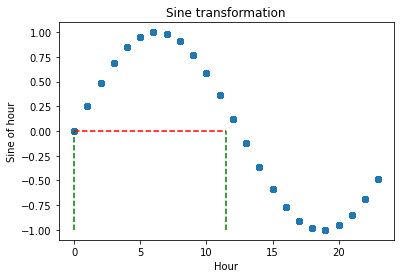

In [50]:
plt.scatter(df["hour"], mainDf["hour_sin"])

# Axis labels
plt.ylabel('Sine of hour')
plt.xlabel('Hour')
plt.title('Sine transformation')

plt.hlines(y=0, xmin=0, xmax=11.5, color='r', linestyles='dashed')

plt.vlines(x=0, ymin=-1, ymax=0, color='g', linestyles='dashed')
plt.vlines(x=11.5, ymin=-1, ymax=0, color='g', linestyles='dashed')

Adding the cosine function, which is out of phase with the sine function, breaks the symmetry and assigns a unique codification to each hour.
 The hour 0, after the transformation, takes the values of sine 0 and cosine 1, which makes it different from the hour 11.5, which takes the values of sine 0 and cosine -1. In other words, with the two functions together, we are able to distinguish all observations within our original variable.

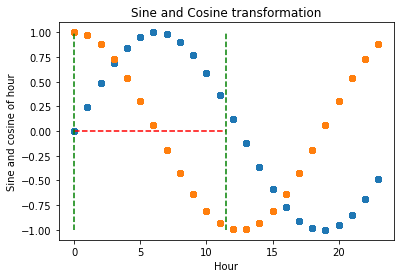

In [51]:

plt.scatter(df["hour"], mainDf["hour_sin"])
plt.scatter(df["hour"], mainDf["hour_cos"])

# Axis labels
plt.ylabel('Sine and cosine of hour')
plt.xlabel('Hour')
plt.title('Sine and Cosine transformation')


plt.hlines(y=0, xmin=0, xmax=11.5, color='r', linestyles='dashed')

plt.vlines(x=0, ymin=-1, ymax=1, color='g', linestyles='dashed')
plt.vlines(x=11.5, ymin=-1, ymax=1, color='g', linestyles='dashed')

vizualising  the (x, y) circle coordinates generated by the sine and cosine features.

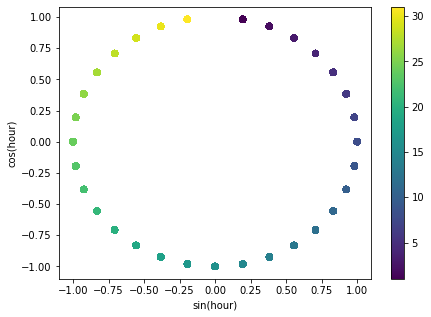

In [52]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(mainDf["day_sin"], mainDf["day_cos"], c=df["day"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)